# PyGEM MCMC calibration analysis - individual glacier

Brandon Tober, David Rounce<br>
Carnegie Mellon University<br>
20241115<br><br>

The main objective of this notebook is to assess the prior and posterior distribution of model parameters following Markov Chain Monte Carlo Bayesian model calibration for an individual glacier. 

>**Note:** for MCMC analysis, the desired glacier must first be calibrated using the **MCMC** option, which requires several preliminary steps. See the *run_calibration.ipynb* Jupyter Notebook for further demonstration.

In [ ]:
### imports ###
import os, pickle, glob, copy, sys, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from scipy.stats import norm, gamma, truncnorm, gaussian_kde
from scipy.stats import gaussian_kde
# pygem imports
from pygem.setup.config import ConfigManager
# instantiate ConfigManager
config_manager = ConfigManager()
# read the config
pygem_prms = config_manager.read_config()   # NOTE: ensure that your root path in ~/PyGEM/config.yaml points to
                                            # the appropriate location. If any errors occur, check this first.
# set some plotting defaults
plt.rcParams["font.family"] = "arial"
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['text.usetex'] = True

In [2]:
# specify glacier number (RGI6 id). here we'll analyze Kennicott Glacier in Alaska's Wrangell Mountains (feel free to swap with a glacier of your liking)
glac_no = 1.15645
prms_path  =f'{pygem_prms['root']}/Output/calibration/{str(glac_no).split('.')[0].zfill(2)}/{glac_no}-modelprms_dict.json'
if os.path.isfile(prms_path):
    with open(prms_path,'r') as f:
        prms = json.load(f)
        if 'MCMC' in prms.keys():
            print(f'MCMC calibration parameters found for {glac_no}, proceed!')
        else:
            print(f'Warning: MCMC calibration parameters not found for {glac_no}! Has MCMC calibration been completed successfully for this glacier?')
else:
    print(f'Warning: Calibration parameter data does not exist for {glac_no}! Has calibration been completed successfully for this glacier?')

MCMC calibration parameters found for 1.15645, proceed!


>**Note:** if a warning appears in the cell above, run MCMC calibration like so:
```bash
!run_calibration -rgi_glac_number {glac_no} -ref_startyear 2000 -ref_endyear 2019 -ref_gcm_name ERA5 -option_calibration MCMC
```

Create a 2x2 plot with the prior and posterior mass balance (`mb_mwea`), precipitation factor (`kp`), temperature bias (`tbias`), and degree day factor of snow (`ddfsnow`).<br><br>

>**Note:** if we had run more than one MCMC calibration chain, we could plot those as well, but here we'll index into the first chain `chain_0`

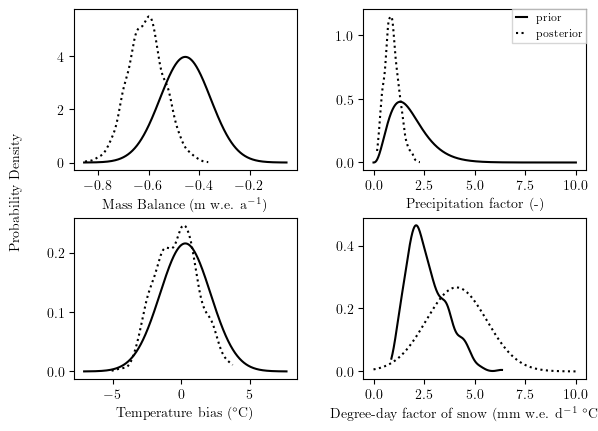

In [3]:
fig,ax = plt.subplots(2,2)

### mb ###
# prior
mean = float(prms['MCMC']['mb_obs_mwea'][0])
std_dev = float(prms['MCMC']['mb_obs_mwea_err'][0])
x_vals = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
pdf_vals = norm.pdf(x_vals, mean, std_dev)
ax[0,0].plot(x_vals, pdf_vals, label='prior', c='k')

data = prms['MCMC']['mb_mwea']['chain_0']
kde = gaussian_kde(data)
x_vals = np.linspace(min(data), max(data), 1000)  # Range for the density curve
y_vals = kde(x_vals)
ax[0,0].plot(x_vals, y_vals, 'k:', label='posterior')
ax[0,0].set_xlabel(r'Mass Balance (m w.e. a$^{-1}$)')

### kp ###
# prior
shape_param = prms['MCMC']['priors']['kp']['alpha']
scale_param = 1/prms['MCMC']['priors']['kp']['beta']
x_vals = np.linspace(0, 10, 10000)
pdf_vals = gamma.pdf(x_vals, a=shape_param, scale=scale_param)
ax[0,1].plot(x_vals, pdf_vals, label='prior', c='k')

# post
data = prms['MCMC']['kp']['chain_0']
kde = gaussian_kde(data)
x_vals = np.linspace(min(data), max(data), 1000)  # Range for the density curve
y_vals = kde(x_vals)
ax[0,1].plot(x_vals, y_vals, 'k:', label='posterior')
ax[0,1].legend(borderaxespad=0,handlelength=1,fancybox=False)
ax[0,1].set_xlabel(' Precipitation factor (-)')

### tbias ###
# prior
mean = prms['MCMC']['priors']['tbias']['mu']
std_dev = prms['MCMC']['priors']['tbias']['sigma']
x_vals = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
pdf_vals = norm.pdf(x_vals, mean, std_dev)
ax[1,0].plot(x_vals, pdf_vals, label='prior', c='k')

# post
data = prms['MCMC']['tbias']['chain_0']
kde = gaussian_kde(data)
x_vals = np.linspace(min(data), max(data), 1000)  # Range for the density curve
y_vals = kde(x_vals)
ax[1,0].plot(x_vals, y_vals, label='posterior', c='k', ls=':')
ax[1,0].set_xlabel(r'Temperature bias ($^{\circ}$C)')

### ddfsnow ###
# prior
mean = prms['MCMC']['priors']['ddfsnow']['mu']*1e3
std_dev = prms['MCMC']['priors']['ddfsnow']['sigma']*1e3
lower_bound = float(prms['MCMC']['priors']['ddfsnow']['low'])*1e3
upper_bound = float(prms['MCMC']['priors']['ddfsnow']['high'])*1e3
a, b = (lower_bound - mean) / std_dev, (upper_bound - mean) / std_dev
trunc_norm_dist = truncnorm(a, b, loc=mean, scale=std_dev)
x_vals = np.linspace(lower_bound, 10, 1000)
pdf_vals = trunc_norm_dist.pdf(x_vals)
ax[1,1].plot(x_vals, pdf_vals, 'k:', label='Truncated Normal PDF')

# post
data = np.asarray(prms['MCMC']['ddfsnow']['chain_0'])*1e3
kde = gaussian_kde(data)
x_vals = np.linspace(min(data), max(data), 1000)  # Range for the density curve
y_vals = kde(x_vals)
ax[1,1].plot(x_vals, y_vals, 'k', label='posterior')
ax[1,1].set_xlabel(r'Degree-day factor of snow (mm w.e. d$^{-1}$ $^{\circ}$C$^{-1}$)')


ax[0,0].text(0, .5, 'Probability Density', horizontalalignment='left', rotation=90,
                    verticalalignment='center', transform=fig.transFigure)
fig.subplots_adjust(hspace=.3,wspace=.3, left=.1,right=.9)

## Next: analyze regional MCMC performance
To analyze the regional performance of MCMC model calibration, see *analyze_regional_mcmc.ipynb*